In [1]:
import pandas as pd
import numpy as np
from fastai.vision import *
from fastai.metrics import error_rate

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ROOT_DIR = '/content/drive/MyDrive/janatahack cv'
IMAGE_DIR = '/content/drive/MyDrive/janatahack cv/train/images/'
MODEL_PATH = ROOT_DIR + '/01_model/'

In [4]:
Df_Train = pd.read_csv('/content/drive/MyDrive/janatahack cv/train/train.csv')

In [5]:
Df_Train.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [9]:
train_src = (ImageList.from_df(df = Df_Train, cols = ['image_names'], path = IMAGE_DIR) \
       .split_by_rand_pct(0.2) \
       .label_from_df(cols = 'emergency_or_not'))
train_src

LabelLists;

Train: LabelList (1317 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,1,0
Path: /content/drive/MyDrive/janatahack cv/train/images;

Valid: LabelList (329 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,1,0,1
Path: /content/drive/MyDrive/janatahack cv/train/images;

Test: None

In [11]:
data = (train_src.transform(get_transforms(), size = 224) \
              .databunch(bs = 32) \
              .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (1317 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,1,0
Path: /content/drive/MyDrive/janatahack cv/train/images;

Valid: LabelList (329 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,1,0,1
Path: /content/drive/MyDrive/janatahack cv/train/images;

Test: None

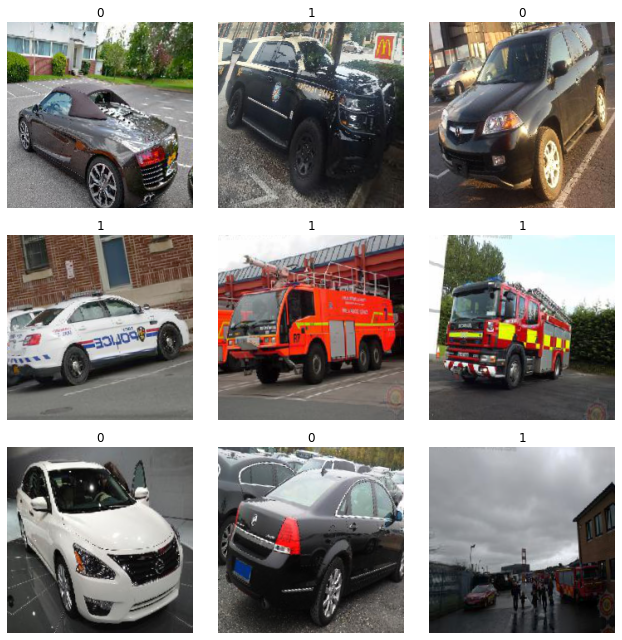

In [12]:
data.show_batch(rows=3, figsize=(9,9))

In [13]:
data.classes,data.c, len(data.train_ds), len(data.valid_ds) 

([0, 1], 2, 1317, 329)

In [14]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [15]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.511443,0.414418,0.103343,12:30
1,0.416090,0.344809,0.100304,12:10
2,0.285227,0.255908,0.069909,12:07
3,0.196562,0.214586,0.057751,12:12
4,0.149713,0.210970,0.060790,12:10


In [16]:
learn.save('stage-1')

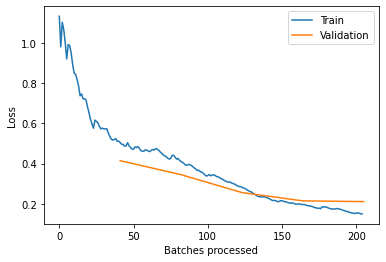

In [17]:
learn.recorder.plot_losses()

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

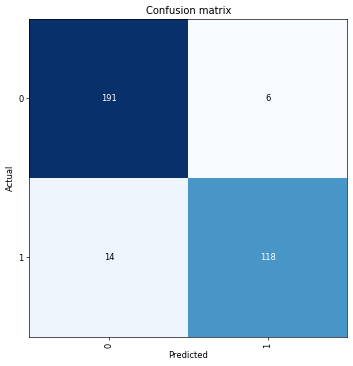

In [19]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

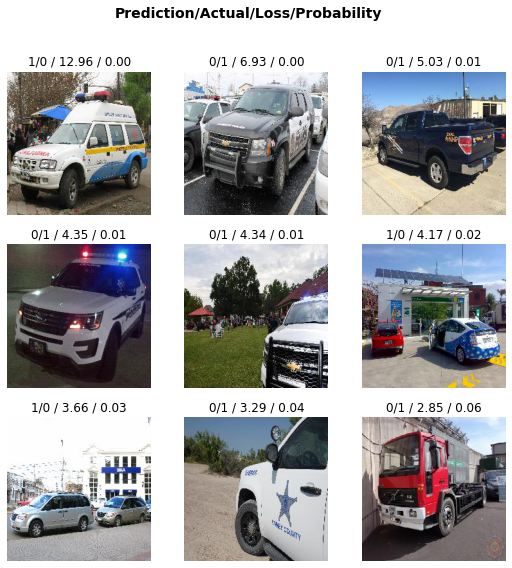

In [20]:
interp.plot_top_losses(9, figsize=(9,9))

In [21]:
Df_Test = pd.read_csv('/content/drive/MyDrive/janatahack cv/test_janatahack_cv.csv')
Df_Test.head()

,image_names
0,1960.jpg
1,668.jpg
2,2082.jpg
3,808.jpg
4,1907.jpg


In [22]:
test_image = Df_Test.sample().iloc[0]['image_names']
test_image_path = IMAGE_DIR + test_image

test_image_path

'/content/drive/MyDrive/janatahack cv/train/images/1783.jpg'

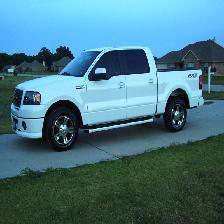

In [23]:
img=open_image(test_image_path)
img

In [24]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_idx

tensor(0)

In [25]:
Df_Sub = pd.read_csv('/content/drive/MyDrive/janatahack cv/sample_submission_janatahack_cv.csv')
Df_Sub.head()

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,0
2,2082.jpg,0
3,808.jpg,0
4,1907.jpg,0


In [26]:
pred_array=[]
for i in range(len(Df_Sub)):
  image = Df_Sub['image_names'][i]
  image_path = IMAGE_DIR + image
  img=open_image(image_path)
  pred_class,pred_idx,outputs = learn.predict(img)
  pred = pred_idx.item()
  pred_array.append(pred)

In [27]:
Df_Sub['emergency_or_not'] = pred_array

In [28]:
Df_Sub.to_csv('submission.csv', index=False)